# Find Line Detection (Image Processing)
Identifying lanes of the road is very common task that human driver performs. It's important to keep the vehicle in the constraints of the lane. We implement a lane line detector for curve lines with the following steps: 

![Line Detection Preview](assets/preview.png?raw=true)

1. Calibration of camera (undistort images)
2. Warp perspective of image with `cv.warpPerspective`
3. Use of white and yellow color masks (`cv.inRange`)
4. Use of [morphological closing](https://en.wikipedia.org/wiki/Closing_(morphology))
5. Sliding windows
6. Curvefitting with calculation of curve radius
7. Creation of lane area by filling polylines of left and right lanes (`cv.fillPoly`)
8. Warp lane area back (`cv.warpPerspective`)
9. Overlay lane area on original frame (`cv.addWeighted`)

## About
This project was developed by Nils-Christopher Wiesenauer (7344312) and Namid Marxen (2975680) on behalf of the image processing lecture during the 5th semester at DHBW Stuttgart. The main purpose of this project is to detect roadway lines.

🚗 We created a pipeline for this lane detection problem.

## Table of Contents
- [Installation and Usage](#installation-and-usage)
- [Functions for detection](#functions-for-detection)
    - [Initialization of packages and global variables](#initialization-of-packages-and-global-variables)
    - [Filers](#filters)
    - [Sliding windows](#sliding-windows)
    - [Curve fitting and radius](#curve-fitting-and-radius)
    - [Apply area](#apply-area)
    - [Manipulation](#manipulation)
    - [Car detection](#car-detection)
- [Exercises](#exercises)
    - [Camera calibration](#camera-calibration)
    - [Segmentation](#segmentation)
    - [Lane detection for KITTI images](#lane-detection-for-kitti-images)
    - [Realtime lane detection](#realtime-lane-detection-for-challenge_video.mp4)
- [Results](#results)
- [Credits](#credits)

## Installation and Usage
To use this project you need to implement:
- [OpenCV](https://opencv.org/)
- [numpy](https://numpy.org/doc/)
- [matplotlib.pyplot](https://matplotlib.org/2.0.2/api/pyplot_api.html)
- [time](https://docs.python.org/3/library/time.html)
- [warnings](https://docs.python.org/3/library/warnings.html)
- [Real-time-vehicle-detection-python](https://github.com/Kalebu/Real-time-Vehicle-Dection-Python)

### Functions for detection
In this section, the necessary functions for lane detection are defined.

#### Initialize packages and datasets
This codeblock initializes all needed packages and global variables.

In [14]:
# Imports
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import time
import warnings
# Dont show warnings
warnings.filterwarnings("ignore")

# number of windows for sliding windows 
nwindows = 180

# value for last radius
last_r = None

# For radius calculation (pixels to meters)
y_m_per_pix = 30 / 720
x_m_per_pix = 3.7 / 1280

# Source and destination for perspective transformation
src = np.array([[598, 448], [684, 448], [1026, 668], [278, 668]], np.float32)
dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Kernels for filter operations
kernel_small = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], 'uint8')
kernel_large = np.array([[0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0]], 'uint8')

# ROI (trapezoid)
#ROI = np.array([[(570, 450),(650, 450),(1300, 650),(200, 650)]], dtype= np.int32)

### Filters
In this subsection we define all needed color, convolution and morphological  filters.

- Color filter:
    - The function `color_space(img)` applies a yellow and white mask on a BGR image  

- Convolution filter:
    - The function `canny_space(img, lower, upper)` returns edges of a gray image by equalizing the image histogramm, applying gaussian blur and using `cv.Canny`

- Morphological filter:
    - Dilatation (`dilate(img, iterations)`): Expands the shapes of the image
    - Erosion (`erode(img, iterations)`): Reduces the shapes of the image
    - Closing (`close(img, iterations)`): Removes noises

In [2]:
# Convert image to yellow and white color space
def color_space(img):
    # Convert image to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # Colorspace "yellow" in HSV: (15-40, 80-255, 160-255)
    mask_yellow = cv.inRange(img_hsv, (15, 80, 160), (40, 255, 255))
    # Colorspace "white" in HSV: (0-255, 0-20, 200-255)
    mask_white = cv.inRange(img_hsv, (0, 0, 200), (255, 20, 255))
    # Merge white and yellow masks
    masks = cv.bitwise_or(mask_yellow, mask_white)
    # Return image in gray
    return cv.cvtColor(cv.bitwise_and(img, img, mask=masks), cv.COLOR_BGR2GRAY)

# Apply canny filter to image
def canny_space(img, lower=80, upper=200):
    # Equalize histogramm with gray image
    equalized_gray_image = cv.equalizeHist(img)
    # Blur image three times
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    # Return image with canny filter
    return cv.Canny(equalized_gray_image, lower, upper) 

# Dilate image (Expands the shapes of the image)
def dilate(img, iterations):
    return cv.dilate(img, kernel_small, iterations=iterations)

# Erode image (Reduces the shapes of the image)
def erode(img, iterations):
    return cv.erode(img, kernel_small, iterations=iterations)

# Close image (Removes noises)
def close(img, iterations):
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel_large, iterations=iterations)

### Sliding windows

The sliding window function (`sliding_windows(warped_img, margin, minimum)`) determines points for curve fitting with the following algorithm and steps:
1. Determine spikes of histogram to calculate starting points
2. Go through every window of a number of windows:
    - Calculate the optimal center of the window on the left and right side
    - Add the centers of the windows to an array

This way, a set of points is converted to one point.
A window "slides" from the bottom to the top of the image along the curve.

![Sliding-window-example](assets/sliding_window.png?raw=true)

In [3]:
def sliding_windows(warped_img, margin=200, minimum=30):
    # Histogram for image
    hist = np.sum(warped_img[warped_img.shape[0]//2:, :], axis=0)
        
    # Take peaks from left and right side of histogramm for starting points and add half margin
    mid = np.int(hist.shape[0] // 2)
    leftx_start = np.argmax(hist[:mid]) - margin // 2
    rightx_start = np.argmax(hist[mid:]) + mid + margin // 2

    # Window height based on number of windows
    window_height = np.int(warped_img.shape[0] // nwindows)
    
    # Calc points that are not zero in images
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Initialize current positions for windows
    leftx_current = leftx_start
    rightx_current = rightx_start

    # Initialize values to be returned -> centers of windows
    lefts_good = np.empty(shape=(1,1), dtype=int)
    rights_good = np.empty(shape=(1,1), dtype=int)

    # Go through every window
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_img.shape[0] - (window + 1) * window_height
        win_y_high = warped_img.shape[0] - window*window_height
        
        # Calculate boundaries of the window
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low =  rightx_current - margin 
        win_xright_high = rightx_current + margin  
        
        # Identify the pixels that are not zero within window
        left_inds = ((nonzeroy >= win_y_low ) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= win_y_low ) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # If more than minimum pixels are found -> recenter next window
        if len(left_inds) > minimum:
            leftx_current = np.int(np.mean(nonzerox[left_inds]))
        if len(right_inds) > minimum:
            rightx_current = np.int(np.mean(nonzerox[right_inds]))

        # Add centers of windows to array
        lefts_good = np.append(lefts_good, leftx_current)
        rights_good = np.append(rights_good, rightx_current)
    return mid, lefts_good, rights_good


### Curve fitting and radius

In this subsection we use curve fitting to calculate the radius of the curve.

Before we can use this formula, we need to do the following steps:
1. Calculate curve (`calc_curve(leftx, rightx, img)`): Calculates a function with polyfit with the given input points (from sliding window)

2. Calculate radius (`calc_radius(left_fit, right_fit, leftx, rightx)`): Calculates the function with polyfit again, but fittet to meters, not to pixels and calls `cal_r(street_area, x_range)` for the left and right curve.

3. Calculate radius degree (`cal_r(street_area, x_range)`): Selects median x of input x-values (middle of the curve) and calculates radius by the following formula:
![Formula curve radius calculation](assets/curve_radius.png?raw=true)

In [4]:
# Calculate curves of lanes with polyfit function
def calc_curve(leftx, rightx, img):
    y = np.linspace(len(img), 0, nwindows+1).astype(int)
    left = np.polyfit(leftx, y, deg=2) 
    right = np.polyfit(rightx , y, deg=2)
    # Calculate radius for curves
    radius = calc_radius(left, right, leftx, rightx)
    return left, right, radius

# Calculate radius for two lines
def calc_radius(left_fit, right_fit, leftx, rightx):
    global last_r
    # Functions for curves by polyfit
    left_fitx = left_fit[0]*leftx**2 + left_fit[1]*leftx + left_fit[2]
    right_fitx = right_fit[0]*rightx**2 + right_fit[1]*rightx + right_fit[2]
    
    # Calculate functions again with meters for values
    left_fit_curve = np.polyfit(leftx*x_m_per_pix, left_fitx*y_m_per_pix, deg=2)
    right_fit_curve = np.polyfit(rightx*x_m_per_pix, right_fitx*y_m_per_pix, deg=2)
    
    # radius of curve
    left = cal_r(left_fit_curve, leftx)
    right = cal_r(right_fit_curve, rightx)

    # Take average from last radius and current radius (if last_r is not None)
    if (last_r != None):
        radius = round(np.mean([left, right, last_r]),0)
    else:
        radius = round(np.mean([left, right]),0)

    # Save current radius for next calculation
    last_r = round(np.mean([left, right]),0)
    return radius

# Calcurate curve radius | R_curve = ((1 + (2*w2*x + w1)^2)^3/2) / | 2*w2 |
def cal_r(street_area, x_range):
    # Take median from x values
    x = np.median(x_range * x_m_per_pix)

    # Calculation
    radius = ((1 + (2 * street_area[0] * x + street_area[1])**2)**(3/2)) / abs(2 * street_area[0])
    return radius

### Apply area
Functions to show the results on an image:

1. Calc lanes (`calc_lanes(street_area, midpoint, isleft)`):
    - Calculates points for the given function that can be applied onto an image
    - Calculate extrem point for curve
    - Select upper and lower boundaries and use extreme value if neccesary, so that the curve does not go over the extreme point
    - Return the calculated points as xy-tupels

- Calc area (`calc_area(img, left_points, right_points, with_alpha=False)`):
    - Returns an image with the area between two lanes colored.
    - Either color the image green (3 channels), or white (1 channel)
    - Sort left and right points by y-values and flip the right points, so that polyfit can interpret it

In [5]:
# Calculate points for lanes
def calc_lanes(street_area, midpoint, isleft):
    # Calculate extreme value for curve
    # DGL: ax^2 + bx + c -> 2ax + b = 0 -> x = (-b/2)/a
    x_extreme = (-street_area[1]) / 2 / street_area[0]

    # Set lower and upper boundaries
    if(isleft):
        lower = 50
        upper = midpoint
    else: 
        lower = midpoint
        upper = 1200
    
    diff_lower = abs(lower - x_extreme) # distance left to extreme point
    diff_upper = abs(upper - x_extreme) # distance right to extreme point
    
    
    # Define x values
    # if left is closer to extreme point -> set extreme point as lower boundary
    if (diff_lower < diff_upper):
        x = np.linspace(x_extreme, upper, 4500).reshape(-1, 1)
    # if right is closer to extreme point -> set extreme point as upper boundary
    else:
        x = np.linspace(lower, x_extreme, 4500).reshape(-1, 1)

    # Get y values from polyfit function
    y = (street_area[0] * (x**2) + street_area[1] * x + street_area[2]).reshape(-1, 1)

    # Merge points -> [[p1], [p2]...]
    xycoor = np.concatenate((x,y), axis=1)
    return xycoor

# Create area between lanes
def calc_area(img, left_points, right_points, with_alpha=False):
    # If with_alpha is True -> Make image colored
    if(with_alpha):
        zero_img = np.zeros((len(img), len(img[0]), 3))
    else:
        zero_img = np.zeros((len(img), len(img[0])))

    # sort by y values
    left_points = left_points.astype(np.int32)[np.argsort(left_points[:, 1])]
    right_points = right_points.astype(np.int32)[np.argsort(right_points[:, 1])][::-1]

    # Merge points -> [[p1], [p2]...]
    points = np.concatenate((left_points, right_points))

    # If with_alpha is True -> color image green, else color it white
    if(with_alpha):
        cv.fillPoly(zero_img, [points], color=[0,255,0])
    else:
        cv.fillPoly(zero_img, [points], color=255)
    return zero_img

### Manipulation
This subsection implements functions for image manipulation:

- Warp image perspective (`warp(img, src, dst)`)
    - Changes the image perspective by transforming the source (src) points to destination (dst) points by performing the `cv.warpPerspective` function

- Crop (`crop(img, ROI)`)
    - Crops the image with the given Region of Interest (ROI) 

- Merge (`merge(frame, img1, img2)`)
    - Merges to images to one. This function is used to merge color_space and canny_space.

- Overlay (`overlay_alpha(img, overlay), overlay(img, overlay`)
    - Overlays the given image (img) with the overlay image with or without alpha.

In [6]:
# Warp image perspective
def warp(img, src=src, dst=dst):
    M = cv.getPerspectiveTransform(src, dst)
    return cv.warpPerspective(img, M, (img.shape[1], img.shape[0]))

# Crop image for region of interest
def crop(img, ROI):
    # Create blank img with same size as input img
    blank = np.zeros(img.shape[:2], np.uint8)

    # Fill region of interest
    region_of_interest = cv.fillPoly(blank, ROI, 255)

    # Create image of interest with region (resize)
    return cv.bitwise_and(img, img, mask=region_of_interest)

# Merge to masks
def merge(frame, img1, img2):
    both = frame.copy()
    both[np.where(np.logical_and(img1==0, img2==0))] = 0
    return both

# Overlay two images
def overlay(img, overlay):
    img[np.where(overlay!=0)] = [0,255,0]
    return img

# Overlay two images with alpha
def overlay_alpha(img, overlay):
    return cv.addWeighted(img, 1, overlay.astype(np.uint8), 0.5, 0.0)

### Car detection
Our car detection uses the haar features .xml-file from Kelbu's real-time vehicle detection on [GitHub](https://github.com/Kalebu/Real-time-Vehicle-Dection-Python).

We do the following two steps to detect cars:
1. Detection of car (`detect_cars(frame)`) by using the `cv.CascadeClassifier` function with information of our haar features from Kelbu.
2. Highlighting detected cars (`highlight_cars(frame, cars)`) by overlaying a green rectangle with `cv.rectangle` and a text with `cv.putText` on the original frame. 

In [7]:
# Import haar features for car detection - credits to Kelbu (https://github.com/Kalebu/Real-time-Vehicle-Dection-Python)
cars_cascade = cv.CascadeClassifier('assets/haarcascade_car.xml')

# Detection of cars
def detect_cars(frame):
    cars = cars_cascade.detectMultiScale(frame, 1.15, 4)
    return cars

# Highlight cars -> Put rectangle and text around them
def highlight_cars(frame, cars):
    # Rectangle for every car that was found
    for (x, y, w, h) in cars:
        cv.rectangle(frame, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
        cv.putText(frame, "Car", (x + w // 2-20, y + h + 20), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    return frame

## Exercises
This section contains all exercises which needs to be solved.

- Show image (`show_img(plt, title, img, numCols, pos, cmap)`)
    - Shows image on a defined plot

In [8]:
# Show image inside defined plot
def show_img(plt, title, img, numCols, pos, cmap):
    plt.subplot(1, numCols, pos)
    plt.title(title)
    plt.imshow(img, cmap)

### Camera calibration
Exercise: Perform camera calibration (for Udacity image sources) and perspective transformation.

The images for calibrations include a chessboard with 9 rows and 6 columns. The defined rows and columns are not working for three images (calibration1.jpg, calibration4.jpg and calibration5.jpg). This can be ignored, because 17 images are enough for calibration.

We perform the following steps for `show_chess_calibration()`:
1. Use of `calibrate_image(x)` to read calibration image, find and show chessboard corners and append found points to `imgpoints` array.
2. Use of `undistort_image(img)` function to undistort the image.
3. Shows images: the original one, the image with chessboard corners and the undistorted image.


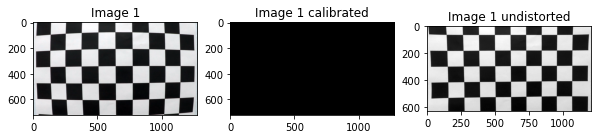

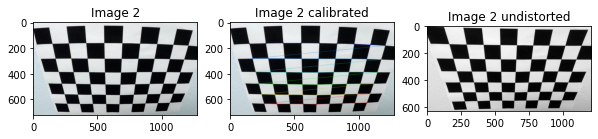

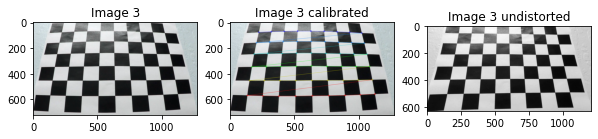

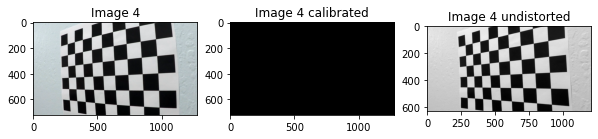

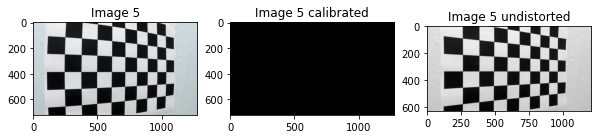

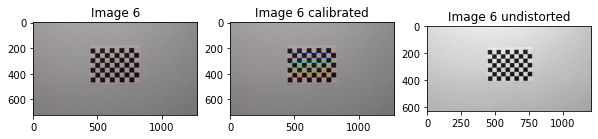

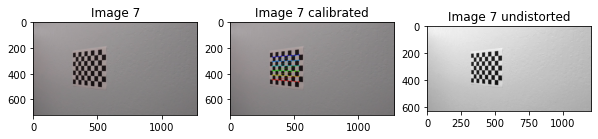

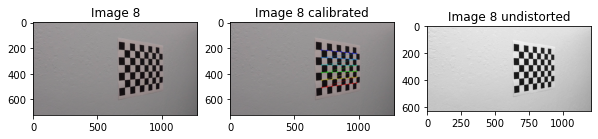

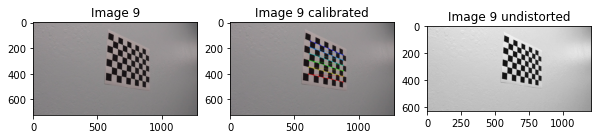

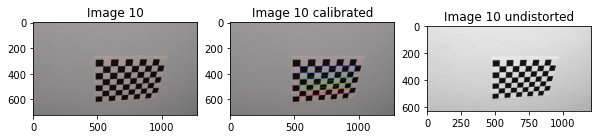

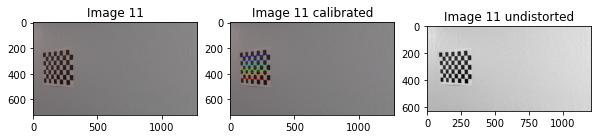

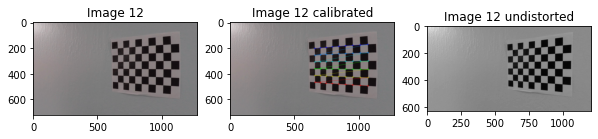

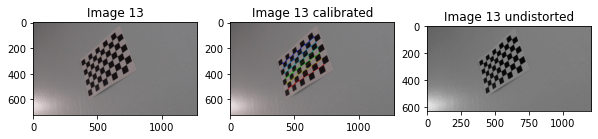

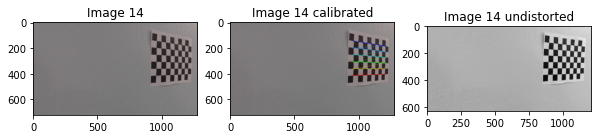

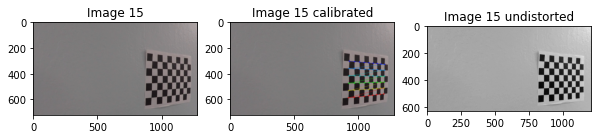

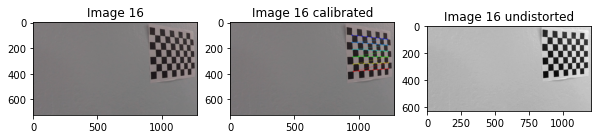

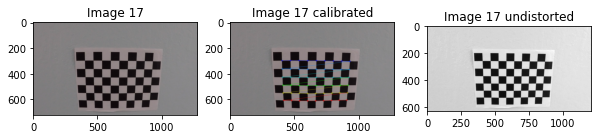

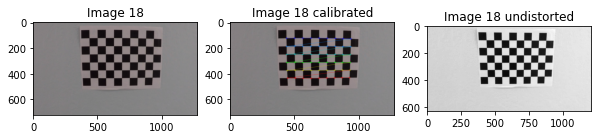

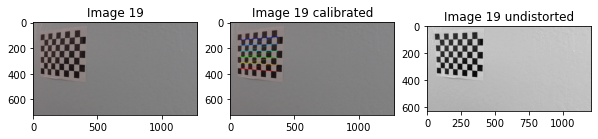

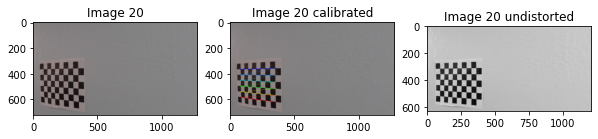

In [9]:
# Define columns and rows for chess board
width = 9
height = 6

# Arrays for obj and image points
objpoints = []
imgpoints = []

objp = np.zeros((width*height, 3), np.float32)
objp[:,:2] = np.mgrid[:width, :height].T.reshape(-1, 2)

# Calibrate image
def calibrate_image(x):
    # Read image and convert to gray
    image_path = './img/Udacity/calib/calibration' + str(x + 1) + '.jpg'
    img = cv.imread(image_path, -1)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find chess board corners
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    ret, corners = cv.findChessboardCorners(img, (width, height), None)
    
    # If corners are found add to obj array -> else return empty image
    if ret == True:
        # Add object points to array
        objpoints.append(objp)

        # Create corners and draw on image
        corners = cv.cornerSubPix(img_gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        drawn = cv.drawChessboardCorners(img, (width, height), corners, ret)
    else:
        drawn = np.zeros_like(img)
    return drawn

# Undistort image
def undistort_image(img):
    # Convert to gray and calibrate with found points
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)

    # Find new camera matrix and undistort with that matrix
    h, w = img_gray.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv.undistort(img_gray, mtx, dist, None, newcameramtx)

    # Crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

def show_chess_calibration():
    all_images = [None]*20

    # First: calibrate all images
    for x in range(20):
        all_images[x] = []
        all_images[x].append(calibrate_image(x))

    # Then: undistort all images
    for x in range(20):
        image_path = './img/Udacity/calib/calibration' + str(x + 1) + '.jpg'
        img = cv.imread(image_path, -1)
        all_images[x].append(undistort_image(img))

        # Show original, calibrated image and undistorted image
        plt.figure(figsize=(10,10))
        show_img(plt, 'Image ' + str(x + 1), img, 3, 1, 'gray')
        show_img(plt, 'Image ' + str(x + 1) + ' calibrated', all_images[x][0], 3, 2, None)
        show_img(plt, 'Image ' + str(x + 1) + ' undistorted', all_images[x][1], 3, 3, 'gray')
        plt.show()
show_chess_calibration()

### Segmentation
Exercise: Restrict the image to the area where the lanes are located.

Here we perform the `warp(img)` function to apply perspective transformation on all Udacity pictures.

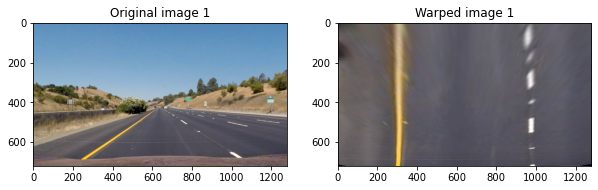

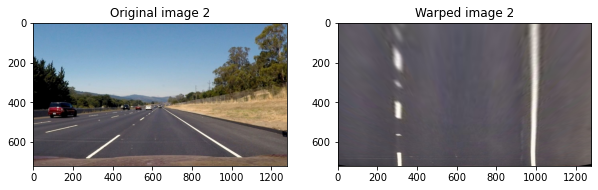

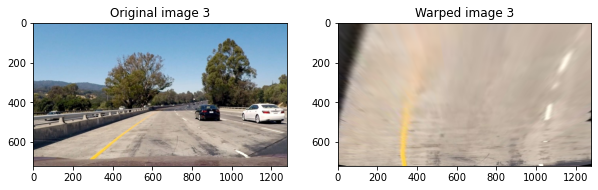

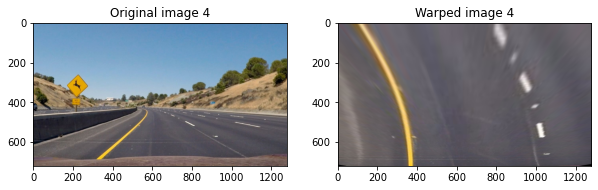

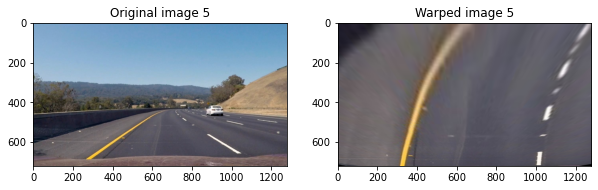

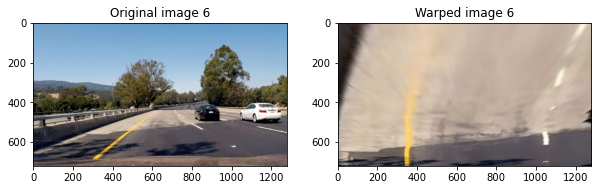

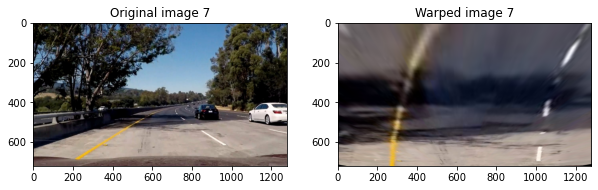

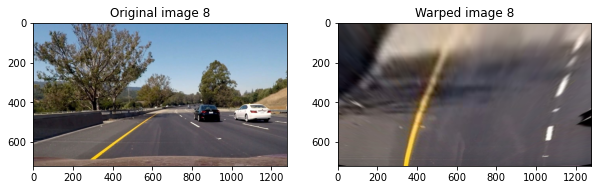

In [10]:
def image_segmentation():
    for x in range(8):    
        # Read image, convert to rgb and warp it
        img = cv.imread('./img/Udacity/image00' + str(x + 1) + '.jpg', -1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_warped = warp(img)

        # Show images
        plt.figure(figsize=(10,10))
        show_img(plt, 'Original image ' + str(x + 1), img, 2, 1, None)
        show_img(plt, 'Warped image ' + str(x + 1), img_warped, 2, 2, None)
        plt.show()
image_segmentation()

### Lane detection for KITTI images

Before applying our detection pipeline to the project_video.mp4 we want to test is with the given KITTI images:

Steps (8) to do:
1. We adjust the pipeline settings (e.q. ROI) and enumerate all KITTI images
2. We read the image and convert it from BGR to RGB
3. We apply the canny edge filter to the grayed frame followed by cropping and warping
4. We create our color space 
5. Apply sliding windows with both (canny edges and color space)
6. Calculate curve and radius
7. Fill area with color and warp image back
8. Show results

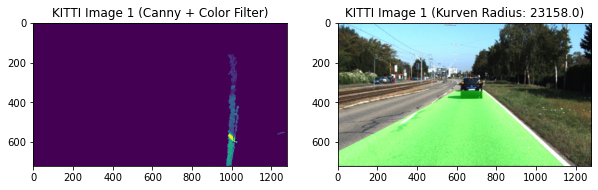

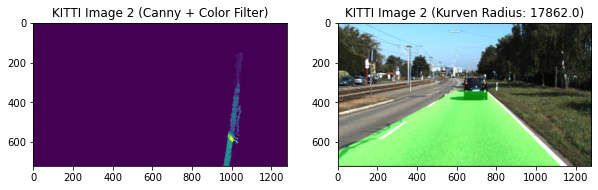

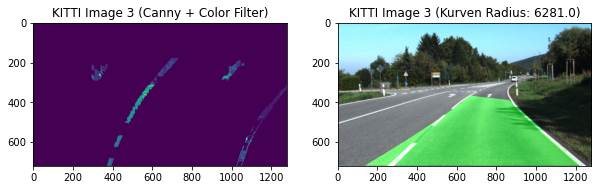

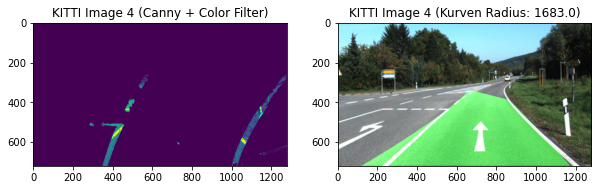

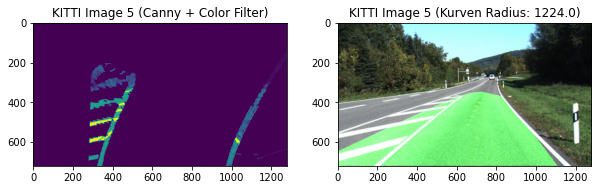

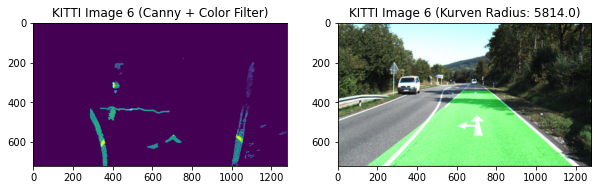

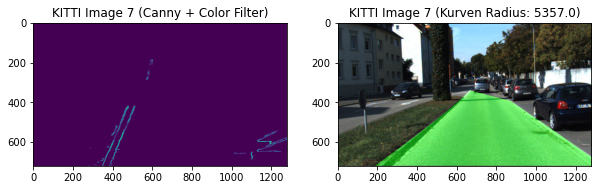

In [11]:
def calc_kitti_images():
    imgs = ['09', '10', '11', '12', '13', '14', '15']

    # Step 1: Define source and destination for transformation
    src = np.array([[595, 340], [730, 340], [1150, 720], [145, 720]], np.float32)
    dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

    # Define ROIs for cropping
    ROI = np.array([[(570, 360), (1150, 340), (1150, 720), (1000, 720) , (700, 480), (350, 720), (115, 720)]], dtype=np.int32)
    ROI2 = np.array([[(525, 400), (1150, 400), (1250, 720), (1000, 720) , (700, 480), (350, 720), (115, 720)]], dtype=np.int32)

    # Iterate through all images
    for img_num, img in enumerate(imgs):   
        # Step 2: Read image and convert into rgb
        frame = orig = cv.imread('./img/KITTI/image0' + img + '.jpg', -1)
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        # Step 3: Canny edge -> Convert to gray, calculate canny and crop image, then transform result
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        canny = canny_space(gray, 100, 200)
        canny = crop(canny, ROI2)
        canny_t = warp(canny, src, dst) 

        # Step 4: Color space -> Crop image, transform image and apply color filters
        cropped = crop(frame, ROI)
        frame = warp(cropped, src, dst) 
        color = color_space(frame) 
             
        # Step 5: Sliding windows for merged canny and color filters    
        midpoint, lefts, rights = sliding_windows(merge(gray, canny_t, color))
        
        # Step 6: Calculate curve and radius
        left_fit, right_fit, radius = calc_curve(lefts, rights, frame)

        # Step 7: Fill area with color, warp back and overlay with original image. Convert image to RGB
        AOI = calc_area(frame, calc_lanes(left_fit, midpoint, True), calc_lanes(right_fit, midpoint, False), True)
        AOI = warp(AOI, dst,src)
        frame = overlay_alpha(orig, AOI)
        frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)

        # Show images
        plt.figure(figsize=(10,10))
        show_img(plt, 'KITTI Image ' + str(img_num + 1) + " (Canny + Color Filter)", merge(gray, canny_t, color), 2, 1, None)
        show_img(plt, 'KITTI Image ' + str(img_num + 1) + " (Kurven Radius: " + str(round(radius)) + ")", frame, 2, 2, None)
        plt.show()
calc_kitti_images()

### Realtime lane detection
Apply functions for lane detection on video (either project or challenge video)
Car detection can be manually turned on, by setting the variable `CAR_DETECTION` to **True**

Iterate through every frame from video:
- Calculate frame rate
- Calculate steps for lane detection only every fifth frame (for performance reasons):
    1. Perform perspective transform on image
    2. Apply color mask to detect yellow and white lanes and close image to reduce noise
    3. Apply sliding windows to find points for curve
    4. Calculate curve and radius
    5. Fill area and transform area image back
- Overlap area imgage on every frame to original
- Show curve radius and fps count

In [17]:
# Open video file
video_file = 'project'
cap = cv.VideoCapture('./img/Udacity/' + video_file + '_video.mp4')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
CHALLENGE = (video_file == 'challenge') 
if(CHALLENGE):
  src = np.array([[600, 480], [760, 480], [1026, 700], [278, 700]], np.float32)
  dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Check if camera opened successfully
if (cap.isOpened() == False):
  print("Error opening video stream or file")

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
while(cap.isOpened()):
  ret, frame = cap.read()

  # Check if there is another frame
  if (frame is None):
    break
  orig = frame.copy()

  # Calculate Frame rate
  frame_count += 1
  ellapsed_time = time.time() - start_timer
  frame_rate = frame_count / ellapsed_time  

  # Calculate curve area only every fifth frame for performance reasons
  if (frame_count % 5 == 0):
    # Detect cars if car detection is on
    if (CAR_DETECTION):
      cars = detect_cars(frame)

    # Step 1: Warp image
    frame = warp(frame, src, dst)
   
    # Step 2: Apply color mask and close image for get rid of small distrubances
    color = color_space(frame)
    color = close(color, 10)

    # For challenge video: dilate and crop color mask
    if(CHALLENGE):
      color = dilate(color, 10)
      ROI = np.array([[(525, 360), (1150, 340), (1150, 720), (900, 720) , (700, 550), (350, 720), (115, 720)]], dtype=np.int32) 
      color = crop(color, ROI) 
    
    # Step 3: Sliding windows to get curve points    
    midpoint, lefts, rights = sliding_windows(color)

    # Step 4: Calculate curve and radius
    left_fit, right_fit, radius = calc_curve(lefts, rights, orig)
  
    # Step 5: Fill area and transform area back
    AOI = calc_area(frame, calc_lanes(left_fit, midpoint, True), calc_lanes(right_fit, midpoint, False), False)
    AOI = warp(AOI, dst, src)
  
  # Overlay street area on every image
  frame = overlay(orig, AOI)

  # If car detection is on: Draw rectangles around cars
  if (CAR_DETECTION):
    frame = highlight_cars(frame, cars)

  if ret == True:      
    # Add frame rate to video
    cv.putText(frame, "FPS: "+ str(round(frame_rate)), (0, 25), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv.LINE_AA)
    
    # Show curve radius (not for challenge video)
    if(not CHALLENGE):
      cv.putText(frame, "Curve radius: " + str(round(radius)).replace(".0", "") + "m", (len(frame[0])//2-150, 25), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2, cv.LINE_AA)
    cv.imshow('Frame', frame)

    # Close video with letter 'q'
    if cv.waitKey(25) & 0xFF == ord('q'):
      break
  else: 
    break

# When everything done, release the video capture object
cap.release()
cv.destroyAllWindows()

## Results
Results and insights we gained from this project:

- Prioritizing lanes is not neccessary, because we crop the image to the region of interest.
- We reach real-time by only proccessing every fifth frame.
- We tried many approaches (using canny edge filter or using canny edge filter plus color filter), but in the end the best results where reached by only using color filters.
- Morphological filters (dilatation, erosion and closing) were very useful and helped to get better results. 
- Our first approaches worked only by putting the pixels from the color filter mask into the polyfit function, but the sliding windows algorithm lead to way better results.
- We also tried using [Chebyshev.fit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.Chebyshev.fit.html), but polyfit worked much besser.
- We noticed that overlapping the mask with the original image, drains a lot of ressources.
- The solution only works for project and challenge video, but not for harder challenge.
- Paint was useful for debugging ❤️

In conclusion, we needed to apply a lot of knowledge of image proccessing in general (also from the lecture), but to get the best results it was neccessary to adjust small parameters and often not whole concepts.

## Credits
Credits to [Dr. Daniel Slieter](https://www.xing.com/profile/Daniel_Slieter) for providing us with material from lectures in digital image processing and to [Kelbu's](https://github.com/Kalebu/Real-time-Vehicle-Dection-Python) haar feature .xml-file for car detection.